# Predicting Exchange Rates for US Dollar to Euro

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Exchange Rate Data
Exchange rate for US Dollars to Euros from August 2008 through August 2018 as found at https://fred.stlouisfed.org/series/DEXUSEU

In [4]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


In [9]:
USEU_data = USEU_raw

# convert index to datetime
USEU_data['Date'] = USEU_raw['Time Period']
USEU_data.index = pd.to_datetime(USEU_raw['Date'])

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU', 'Date'])

# Remove NAs
USEU_data.dropna(inplace=True)

USEU_data.shape

(4189, 1)

In [10]:
USEU_data.head()

,Rate
Date,
2002-01-02,0.9031
2002-01-03,0.8992
2002-01-04,0.8946
2002-01-07,0.8931
2002-01-08,0.8925


In [11]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,4189.0,1.25222,0.141234,0.8594,1.1534,1.2684,1.3494,1.601


Text(0.5,1,'Histogram of Exchange Rates')

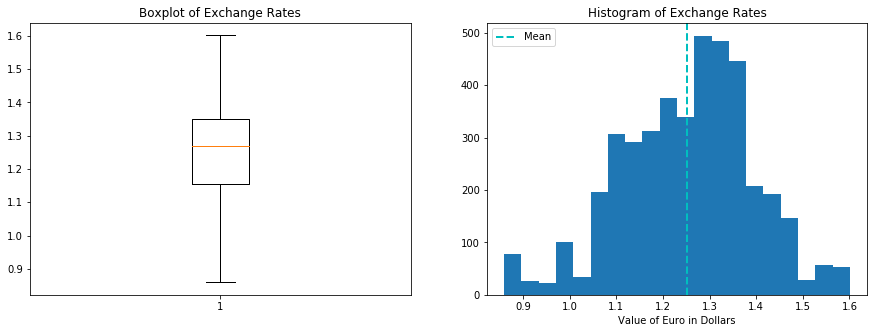

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate.dropna(how = 'any'))
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate.dropna(how = 'any'), bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')

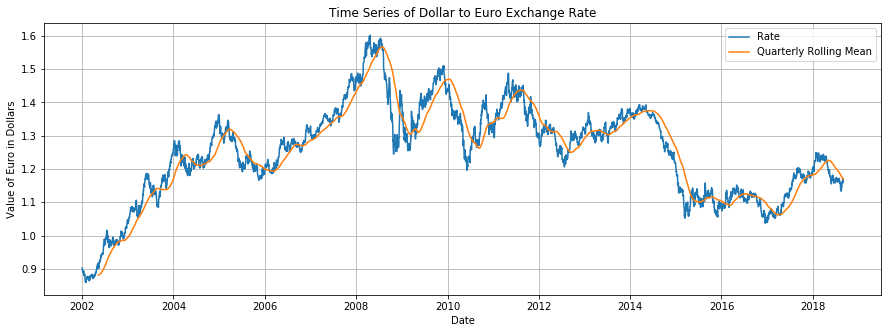

In [13]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(USEU_data.index, USEU_data.Rate)
plt.plot(USEU_data.index, USEU_data.Rate.rolling(window=90,center=False).mean(), label = 'Quarterly Rolling Mean')
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

The value of the euro generally increased from it's initial use in 2002 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015. 

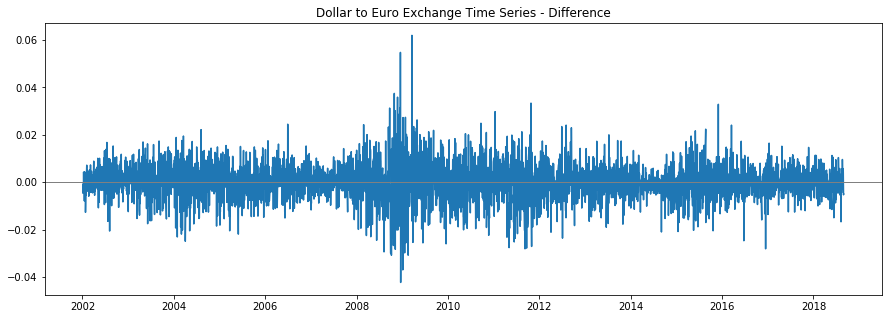

In [15]:
# difference from one record to next
USEU_data['diff_1'] = USEU_data.Rate - USEU_data.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(USEU_data.index, USEU_data.diff_1)
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.title('Dollar to Euro Exchange Time Series - Difference')
plt.show()

By plotting the difference from day to day we see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

### Training and Test

In [ ]:
Train = USEU_data[USEU_data.index < ]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


# Time Series Models
The primary algorithm for time series is the ARIMA model.

## ARIMA model
Auto Regressive Moving Integrated Average<br>
Uses prior values, differences and prior errors to predict future values.

### Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rate, testing for correlation - the values indicate the data shift.

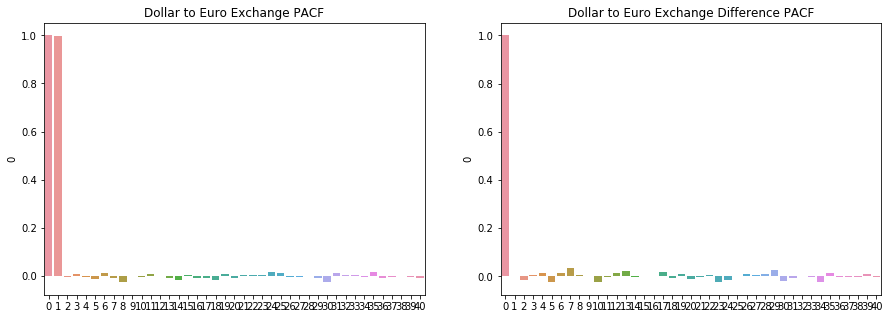

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_acf = pd.DataFrame(pacf(USEU_data.Rate))
sns.barplot(x=x_acf.index, y=x_acf[0])
plt.title("Dollar to Euro Exchange PACF")


plt.subplot(1, 2, 2)
x_acf_diff = pd.DataFrame(pacf(USEU_data.diff_1[1:]))
sns.barplot(x=x_acf_diff.index, y=x_acf_diff[0])
plt.title("Dollar to Euro Exchange Difference PACF")
plt.show()

Running a PACF of the original exchange rate values shows strong auto-correlation at 1.  The PACF of the exchange rate difference values shows no notable auto-correlation.

In [18]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(USEU_data.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-28814.446, BIC=-28801.766, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-28812.496, BIC=-28793.476, Fit time=0.085 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-28812.497, BIC=-28793.477, Fit time=0.067 seconds
Total fit time: 0.829 seconds
-28814.446215529155
